In [77]:
import re
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from soynlp.tokenizer import LTokenizer
from soynlp.normalizer import only_hangle
from sklearn.base import BaseEstimator, TransformerMixin

plt.rc("font", family="Malgun Gothic")
plt.rc("axes", unicode_minus=False)
sns.set_theme(font="Malgun Gothic")
# so.Plot.config.theme.update({
# 	"font.family": ["Malgun Gothic"],
# 	"axes.unicode_minus": False,
# })

In [78]:
with open("ai_score_data/tag_lift.json", encoding="utf-8") as f:
    lift_json = json.load(f)
lift_json

{'체험': {'M': {'아동': 0.986170217,
   '10대': 0.9962233689,
   '20대': 1.0031030024,
   '30대': 1.0207218136,
   '40대': 1.0141414738,
   '50대': 0.9985060003,
   '60대': 0.9893667824,
   '70세 이상': 0.9780767523},
  'F': {'아동': 0.9857188107,
   '10대': 1.0021246371,
   '20대': 1.0107896726,
   '30대': 1.0063649243,
   '40대': 1.0073632351,
   '50대': 0.9900044755,
   '60대': 0.981634374,
   '70세 이상': 0.9845197961}},
 '아동': {'M': {'아동': 1.1166642132,
   '10대': 1.0528059772,
   '20대': 0.9678169805,
   '30대': 0.9776153144,
   '40대': 1.0397506227,
   '50대': 1.0406324939,
   '60대': 1.0384315453,
   '70세 이상': 1.0552903904},
  'F': {'아동': 1.1318194062,
   '10대': 0.9827478427,
   '20대': 0.8104723455,
   '30대': 0.9436096991,
   '40대': 1.0064412853,
   '50대': 1.0104101955,
   '60대': 1.0106112745,
   '70세 이상': 1.0850120601}},
 '문화': {'M': {'아동': 0.9538346745,
   '10대': 0.9775801901,
   '20대': 1.0172231737,
   '30대': 1.0175308275,
   '40대': 0.9916906847,
   '50대': 0.9835204604,
   '60대': 0.9882861645,
   '70세 이상

In [31]:
# import json
# import pandas as pd
#
# # 1) 원본 dict (질문에서 주신 첫 번째 JSON)
# raw = lift_json
#
# # 2) DataFrame으로 변환
# df = pd.DataFrame(raw)
#
# # 0) 태그 한글 매핑
# tag_map = {
# 	"activity": "체험",
# 	"children": "아동",
# 	"culture": "문화",
# 	"food": "먹거리",
# 	"nature": "자연",
# 	"night": "야간",
# 	"season": "계절"
# }
#
# # 3) 연령대 라벨 매핑
# age_map = {
# 	"0~9세": "아동",
# 	"10~19세": "10대",
# 	"20~29세": "20대",
# 	"30~39세": "30대",
# 	"40~49세": "40대",
# 	"50~59세": "50대",
# 	"60~69세": "60대",
# 	"70세 이상": "70세 이상",
# }
# df["tag"] = df["tag"].map(tag_map)
# df["age_group"] = df["age_group"].map(age_map)
#
# # 4) 최종 결과 딕셔너리 생성
# result = {}
#
# for _, row in df.iterrows():
# 	tag = row["tag"]                 # activity / children / ...
# 	sex = row["sex"]                # "남성" / "여성" (그대로 사용)
# 	age = row["age_group"]         # "아동" / "10대" / ...
# 	lift = float(row["lift_gt"])    # 값
#
# 	# 태그별 최상위 dict 초기화
# 	if tag not in result:
# 		result[tag] = {
# 		}
#
# 	# 성별 dict가 없으면 초기화
# 	if sex not in result[tag]:
# 		result[tag][sex] = {}
#
# 	# 성별-연령대별 Lift 채우기
# 	result[tag][sex][age] = lift
#
# # 5) JSON 파일로 저장 (선택)
# with open("lift_by_tag_sex_age.json", "w", encoding="utf-8") as f:
# 	json.dump(result, f, ensure_ascii=False, indent=4)
#
# # 6) 콘솔에서 확인
# print(json.dumps(result, ensure_ascii=False, indent=4))


In [79]:
with open("data/공통정보조회_final.json", encoding="utf-8") as f:
	commoninfo = json.load(f)
commoninfo_df = pd.DataFrame([{"contentid": a.get("contentid"), "title": a.get("title").replace(" ", "")} for a in commoninfo])

with open("data/반복정보조회_final.json", encoding="utf-8") as f:
	detailinfo = json.load(f)
detailinfo_df = pd.DataFrame(detailinfo)[["contentid", "infotext"]].groupby("contentid").agg(" ".join)

with open("data/소개정보조회_final.json", encoding="utf-8") as f:
	detailintro = json.load(f)
detailintro_df = pd.DataFrame(detailintro)[["contentid", "eventstartdate", "eventenddate"]]

In [80]:
festival_df = commoninfo_df.merge(detailinfo_df, on="contentid").merge(detailintro_df, on="contentid")
# festival_df = festival_df[festival_df.eventenddate.map(int) > 20251119].reset_index(drop=True)
festival_df = festival_df.reset_index(drop=True)
festival_df

,contentid,title,infotext,eventstartdate,eventenddate
0,3113671,가락몰빵축제전국빵지자랑,"전국 각지의 농수축산물이 모이는 가락몰에서, 전국 각지의 빵 맛집들이 모여 서울 최...",20250509,20250511
1,3379778,가락옥토버페스트미식야행,전국 각지 농수산물이 모이는 서울시 송파구 가락몰 3층 하늘공원에서 루프탑 야외축제...,20251024,20251026
2,694576,가야문화축제,가야문화축제는 6가야의 맹주였던 금관가야를 바탕으로 한 역사와 전통을 자랑하는 김해...,20250410,20250413
3,712175,가파도청보리축제,가파도 청보리의 품종향맥은 타 지역보다 2배이상 자라는 제주의 향토 품종으로 전국에...,20250404,20250506
4,3503909,가평양떼목장수국축제,"가평의 아름다운 자연 속에서 펼쳐지는 본 축제는, 활짝 핀 가을 수국의 물결과 사랑...",20250627,20251029
...,...,...,...,...,...
763,2991796,DDP여름축제:디자인홀리데이,DDP 여름축제 ‘디자인 홀리데이’는 DDP 사계절 축제 중 여름 휴가철을 맞아 진...,20250731,20250803
764,3486606,"MyOwnPlanet,지구야놀자",서울새활용플라자(SUP)가 2025년 4월 제55회 지구의 날(Earth Day)을...,20250418,20250506
765,3331805,NS푸드페스타,"최고의 맛을 먹고! 보고! 즐기는""NS푸드페스타""는 국내 농수축산업과 식품산업의 발...",20250926,20250927
766,3544786,WOW다놀자!양평페스타,다놀자 양평페스타는 양평캠퍼스 전역이 하나의 거대한 놀이터로 변신하는 특별한 축제이...,20251025,20251026


# 축제 태그 벡터 생성

In [81]:
with open("model/combined_scores_v1.json", encoding="utf-8") as f:
	tokenizer = LTokenizer(scores=json.load(f))

def build_tau_array(tag_names, config, default_th=0.5):
	thres = config.get("thresholds", {})
	tau = np.array([thres.get(tag, default_th) for tag in tag_names], dtype=float)

	return tau

def theta_margin_topk_from_proba(proba, tau, k=2, gamma=1.0):
	n_samples, n_tags = proba.shape
	theta = np.zeros_like(proba, dtype=float)

	for i in range(n_samples):
		p = proba[i]  # (n_tags,)

		# 1) margin score 계산 (top-k 선택용)
		s = np.zeros_like(p, dtype=float)
		above = p >= tau
		s[above] = (p[above] - tau[above]) / (1.0 - tau[above] + 1e-8)

		# 2) margin > 0 후보
		candidates = np.where(s > 0)[0]

		if len(candidates) >= k:
			# 후보 안에서 margin 기준 top-k
			top_idx_in_cand = np.argsort(s[candidates])[-k:]
			top_tags = candidates[top_idx_in_cand]
		elif len(candidates) == 1 and k > 1:
			first = candidates[0]
			# 나머지는 proba 기준으로 채우기
			order = np.argsort(p)
			second = None
			for idx in order[::-1]:
				if idx != first:
					second = idx
					break
			if second is None:
				top_tags = np.array([first])
			else:
				top_tags = np.array([first, second])
		else:
			# 후보 0개 → proba 기준 top-k
			top_tags = np.argsort(p)[-k:]

		# 3) theta 계산: top_tags에 대해서만 확률 기반 가중치
		w = p[top_tags].astype(float)

		# 선택적으로 분포를 조금 평탄/날카롭게 하고 싶으면 gamma 사용
		# gamma < 1  → 차이를 줄임 (more 균등)
		# gamma = 1  → 원래 확률 비율 그대로
		# gamma > 1  → 차이를 키움 (more 쏠림)
		# if gamma != 1.0:
		# 	w = np.power(w, gamma)
		#
		# 음수 방지 (이론상 불필요하지만 안전용)
		w = np.maximum(w, 0.0)

		den = w.sum()
		if den > 0:
            # 합이 1이 되도록 정규화
			w = w / den
		else:
			# 혹시 전부 0이면 균등분배
			w = np.ones_like(w, dtype=float) / len(w)

		theta[i, top_tags] = w

	return theta

def clean_text_model(text: str) -> str:
    text = re.sub(r"\d{4}\s*년", " ", text)
    text = re.sub(r"\d+\s*월", " ", text)
    text = re.sub(r"\d+\s*일", " ", text)
    text = re.sub(r"\d+\s*일간", " ", text)
    text = re.sub(r"\d+\s*박\s*\d+\s*일", " ", text)
    text = re.sub(r"\d+\s*시", " ", text)
    text = re.sub(r"\d+\s*분", " ", text)
    text = re.sub(r"\d+\s*초", " ", text)
    text = re.sub(r"\d+\s*주년", " ", text)
    text = re.sub(r"\d+\s*회", " ", text)
    text = re.sub(r"\d+\s*차", " ", text)
    text = re.sub(r"\d+\s*명", " ", text)
    text = only_hangle(text)
    return " ".join(tokenizer.tokenize(text))

class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([clean_text_model(t) for t in X])

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return np.array(["text"], dtype=object)
        return np.asarray(input_features, dtype=object)

with open("model/config_v1.json", encoding="utf-8") as f:
	config = json.load(f)

with open("model/pipe_ovr_v1.pkl", "rb") as f:
	pipe_ovr = joblib.load(f)

with open("model/tag_name_v1.json", encoding="utf-8") as f:
	tag_name = json.load(f)

tau_array = build_tau_array(tag_name, config)

In [82]:
festival_vector = pd.concat((festival_df, pd.DataFrame(theta_margin_topk_from_proba(pipe_ovr.predict_proba(festival_df.infotext), tau_array), columns=tag_name)), axis=1)
festival_vector

,contentid,title,infotext,eventstartdate,eventenddate,activity,children,culture,food,nature,night,season
0,3113671,가락몰빵축제전국빵지자랑,"전국 각지의 농수축산물이 모이는 가락몰에서, 전국 각지의 빵 맛집들이 모여 서울 최...",20250509,20250511,0.389887,0.610113,0.000000,0.000000,0.000000,0.000000,0.000000
1,3379778,가락옥토버페스트미식야행,전국 각지 농수산물이 모이는 서울시 송파구 가락몰 3층 하늘공원에서 루프탑 야외축제...,20251024,20251026,0.000000,0.000000,0.000000,0.643118,0.000000,0.356882,0.000000
2,694576,가야문화축제,가야문화축제는 6가야의 맹주였던 금관가야를 바탕으로 한 역사와 전통을 자랑하는 김해...,20250410,20250413,0.000000,0.000000,0.606701,0.000000,0.000000,0.393299,0.000000
3,712175,가파도청보리축제,가파도 청보리의 품종향맥은 타 지역보다 2배이상 자라는 제주의 향토 품종으로 전국에...,20250404,20250506,0.481143,0.000000,0.000000,0.518857,0.000000,0.000000,0.000000
4,3503909,가평양떼목장수국축제,"가평의 아름다운 자연 속에서 펼쳐지는 본 축제는, 활짝 핀 가을 수국의 물결과 사랑...",20250627,20251029,0.000000,0.000000,0.000000,0.000000,0.682215,0.000000,0.317785
...,...,...,...,...,...,...,...,...,...,...,...,...
763,2991796,DDP여름축제:디자인홀리데이,DDP 여름축제 ‘디자인 홀리데이’는 DDP 사계절 축제 중 여름 휴가철을 맞아 진...,20250731,20250803,0.412744,0.000000,0.000000,0.000000,0.000000,0.000000,0.587256
764,3486606,"MyOwnPlanet,지구야놀자",서울새활용플라자(SUP)가 2025년 4월 제55회 지구의 날(Earth Day)을...,20250418,20250506,0.483202,0.000000,0.000000,0.000000,0.516798,0.000000,0.000000
765,3331805,NS푸드페스타,"최고의 맛을 먹고! 보고! 즐기는""NS푸드페스타""는 국내 농수축산업과 식품산업의 발...",20250926,20250927,0.463106,0.000000,0.000000,0.536894,0.000000,0.000000,0.000000
766,3544786,WOW다놀자!양평페스타,다놀자 양평페스타는 양평캠퍼스 전역이 하나의 거대한 놀이터로 변신하는 특별한 축제이...,20251025,20251026,0.529425,0.470575,0.000000,0.000000,0.000000,0.000000,0.000000


In [83]:
festival_vectors = festival_vector.rename(columns={
	"activity": "체험",
	"children": "아동",
	"culture": "문화",
	"food": "먹거리",
	"nature": "자연",
	"night": "야간",
	"season": "계절"
})
festival_vectors

,contentid,title,infotext,eventstartdate,eventenddate,체험,아동,문화,먹거리,자연,야간,계절
0,3113671,가락몰빵축제전국빵지자랑,"전국 각지의 농수축산물이 모이는 가락몰에서, 전국 각지의 빵 맛집들이 모여 서울 최...",20250509,20250511,0.389887,0.610113,0.000000,0.000000,0.000000,0.000000,0.000000
1,3379778,가락옥토버페스트미식야행,전국 각지 농수산물이 모이는 서울시 송파구 가락몰 3층 하늘공원에서 루프탑 야외축제...,20251024,20251026,0.000000,0.000000,0.000000,0.643118,0.000000,0.356882,0.000000
2,694576,가야문화축제,가야문화축제는 6가야의 맹주였던 금관가야를 바탕으로 한 역사와 전통을 자랑하는 김해...,20250410,20250413,0.000000,0.000000,0.606701,0.000000,0.000000,0.393299,0.000000
3,712175,가파도청보리축제,가파도 청보리의 품종향맥은 타 지역보다 2배이상 자라는 제주의 향토 품종으로 전국에...,20250404,20250506,0.481143,0.000000,0.000000,0.518857,0.000000,0.000000,0.000000
4,3503909,가평양떼목장수국축제,"가평의 아름다운 자연 속에서 펼쳐지는 본 축제는, 활짝 핀 가을 수국의 물결과 사랑...",20250627,20251029,0.000000,0.000000,0.000000,0.000000,0.682215,0.000000,0.317785
...,...,...,...,...,...,...,...,...,...,...,...,...
763,2991796,DDP여름축제:디자인홀리데이,DDP 여름축제 ‘디자인 홀리데이’는 DDP 사계절 축제 중 여름 휴가철을 맞아 진...,20250731,20250803,0.412744,0.000000,0.000000,0.000000,0.000000,0.000000,0.587256
764,3486606,"MyOwnPlanet,지구야놀자",서울새활용플라자(SUP)가 2025년 4월 제55회 지구의 날(Earth Day)을...,20250418,20250506,0.483202,0.000000,0.000000,0.000000,0.516798,0.000000,0.000000
765,3331805,NS푸드페스타,"최고의 맛을 먹고! 보고! 즐기는""NS푸드페스타""는 국내 농수축산업과 식품산업의 발...",20250926,20250927,0.463106,0.000000,0.000000,0.536894,0.000000,0.000000,0.000000
766,3544786,WOW다놀자!양평페스타,다놀자 양평페스타는 양평캠퍼스 전역이 하나의 거대한 놀이터로 변신하는 특별한 축제이...,20251025,20251026,0.529425,0.470575,0.000000,0.000000,0.000000,0.000000,0.000000


In [97]:
def compute_ai_score_for_user(
	festival_df: pd.DataFrame,
	lift_json: dict,
	sex: str,
	age_group: str,
	prefer_tag: str | None = None,		# 선호 태그 1개 (예: 'food', 없으면 None)
	prefer_boost: float = 1.0,			# 선호 태그에 곱할 계수
	default_lift: float = 1.0,
	eps: float = 1e-8
) -> pd.DataFrame:
	"""
	festival_df: contentid, TAGS 컬럼 포함된 DataFrame
	lift_json: tag -> sex -> age_group -> lift 구조 dict
	sex: 'M' 또는 'F'
	age_group: '아동', '10대', '20대', ..., '70세 이상'
	prefer_tag: 사용자가 선택한 선호 태그 1개 (예: 'food'), 없으면 None
	prefer_boost: 선호 태그에 곱할 계수 (예: 2.0 → 두 배 반영)
	"""
	TAGS = ["체험", "아동", "문화", "먹거리", "자연", "야간", "계절"]

	# 1) 축제별 θ(f,t) 계산
	# 축제 df에 TAGS 컬럼이 "기여도(합≈1)"
	theta = festival_df[TAGS]

	# 2) Lift 기반 사용자 태그 선호도 벡터 Pref(u,t)
	base_pref = np.array([
		lift_json.get(tag, {}).get(sex, {}).get(age_group, default_lift)
		for tag in TAGS
	], dtype=float)

	# 3) 단일 선호 태그 가중치 벡터 w(t)
	tag_weight = np.ones(len(TAGS), dtype=float)
	if prefer_tag in TAGS:
		idx = TAGS.index(prefer_tag)
		tag_weight[idx] = float(prefer_boost)

	# 4) 최종 사용자 선호도 Pref*(u,t) = Pref(u,t) * w(t)
	user_pref = base_pref * tag_weight

	# 5) raw score 계산: θ(f,·) · Pref*(u,·)
	raw_values = theta.values @ user_pref
	raw_scores = pd.Series(
		raw_values,
		index=festival_df["contentid"].values,
		name="raw_score"
	)

	# 6) 0~1 정규화
	s_min = raw_scores.min()
	s_max = raw_scores.max()
	ai_scores = ((raw_scores - s_min) / (s_max - s_min + eps)).rename("ai_score")

	# 7) 원본 df에 merge
	result = festival_df.copy()
	result = result.merge(
		pd.concat([raw_scores, ai_scores], axis=1),
		left_on="contentid",
		right_index=True,
		how="left"
	)

	return result

In [98]:
festival_vectors[festival_vectors.contentid == "3485626"]

,contentid,title,infotext,eventstartdate,eventenddate,체험,아동,문화,먹거리,자연,야간,계절
557,3485626,"인천,사이언스페스티벌",4월 과학의 날을 기념하여 2025 City of Science 인천 과학 축제 <...,20250412,20250412,0.490323,0.0,0.509677,0.0,0.0,0.0,0.0


In [102]:
fuck = compute_ai_score_for_user(festival_vectors, lift_json, sex="F", age_group="20대")[["contentid", "title", "ai_score"]].sort_values("ai_score", ascending=False)
fuck

,contentid,title,ai_score
462,2874909,여수밤바다불꽃축제,1.000000
512,2789700,운정호수공원불꽃축제,0.992453
598,1204941,정월대보름한마당,0.991530
724,631268,한화와함께하는서울세계불꽃축제,0.990821
628,3542294,진주의수호자들-유등빛을지켜라,0.967039
...,...,...,...
721,1883830,한림공원수선화축제,0.015296
75,2872215,고흥유자축제,0.012805
32,2435280,강진만춤추는갈대축제,0.006467
639,2595923,천리포수목원목련축제,0.003808


In [107]:
fuck = compute_ai_score_for_user(festival_vectors, lift_json, sex="F", age_group="20대", prefer_tag="자연", prefer_boost=4)[["contentid", "title", "ai_score"]].sort_values("ai_score", ascending=False)
fuck

,contentid,title,ai_score
578,2965611,전라남도정원페스티벌,1.000000
556,2618014,인제가을꽃축제,0.969816
4,3503909,가평양떼목장수국축제,0.964070
682,1809293,태화강국가정원봄꽃축제,0.962081
223,2755544,릴랙스위크,0.956923
...,...,...,...
270,3486535,봄꽃포레숲숲라이브,0.000786
546,3074902,의왕왕송호수겨울축제,0.000674
45,3049823,겨울엔양평,0.000622
8,1506389,감악산해맞이행사,0.000589


In [61]:
asdfasdf = compute_ai_score_for_user(festival_vectors, lift_json, sex="남성", age_group="30대", prefer_tag="계절", prefer_boost=2)[["contentid", "title", "ai_score"]].sort_values("ai_score", ascending=False).head()
asdfasdf

,contentid,title,ai_score
457,2823399,여름꽃&능소화축제,1.000000
429,3484079,양양생생축제,0.974814
454,2484272,에덴벚꽃길벚꽃축제,0.957761
63,1725993,고양가을꽃축제,0.956697
313,2484871,산청황매산철쭉제,0.951215


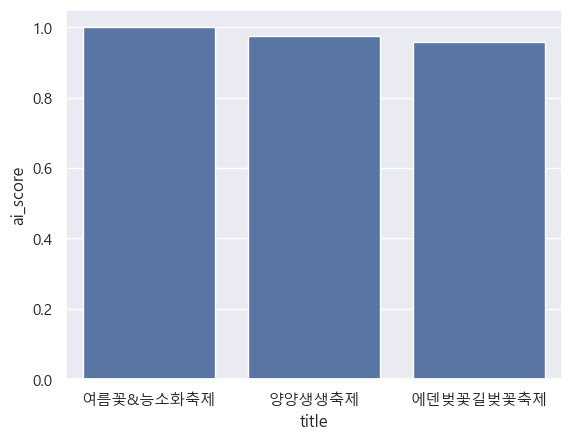

In [62]:
sns.barplot(asdfasdf.head(3), x="title", y="ai_score")
plt.show()

In [18]:
asdfasdf.raw_score.min()

np.float64(0.9664453901450263)

In [19]:
compute_ai_score_for_user(festival_vectors, lift_json, sex="F", age_group="아동")[["contentid", "title", "raw_score", "ai_score"]].sort_values("ai_score", ascending=False)

,contentid,title,raw_score,ai_score
2,3345610,부산국제아동도서전,1.056973,1.000000
3,234232,사천에어쇼,0.985992,0.144898
5,3507590,제민천밤페스타,0.984337,0.124954
0,3563531,구리빛축제,0.982209,0.099323
4,1095732,서울빛초롱축제,0.980453,0.078164
1,3391868,남동빛의거리,0.973965,0.000000


In [20]:
tag_name

['activity', 'children', 'culture', 'food', 'nature', 'night', 'season']

In [21]:
#                         'activity', 'children', 'culture',   'food',    'nature',   'night',    'season'
# 5,평창 설산 눈썰매 겨울축제, 0.504856,   0.495144,   0.000000,   0.000000,  0.000000,   0.000000,    0.000000

In [22]:
lift_json.get("activity").get("M").get("아동") * 0.504856 + lift_json.get("children").get("M").get("아동") * 0.495144

1.0537016547799392

In [23]:
compute_ai_score_for_user(festival_vectors, lift_json, sex="M", age_group="아동")[["contentid", "title", "raw_score", "ai_score"]].sort_values("ai_score", ascending=False)

,contentid,title,raw_score,ai_score
2,3345610,부산국제아동도서전,1.045215,1.000000
5,3507590,제민천밤페스타,1.004016,0.476972
0,3563531,구리빛축제,0.985840,0.246223
4,1095732,서울빛초롱축제,0.984723,0.232035
3,234232,사천에어쇼,0.980599,0.179683
1,3391868,남동빛의거리,0.966445,0.000000


In [24]:
lift_json.get("activity").get("M").get("아동") * 0.504856 * 1.15 + lift_json.get("children").get("M").get("아동") * 0.495144

1.1288062183895229

In [31]:
compute_ai_score_for_user(festival_vectors, lift_json, sex="F", age_group="아동", prefer_tag="food", prefer_boost=1.15)[["contentid", "title", "raw_score", "ai_score"]].sort_values("ai_score", ascending=False).head()

,contentid,title,raw_score,ai_score
5,3507590,제민천밤페스타,1.066553,1.000000
2,3345610,부산국제아동도서전,1.056973,0.896534
3,234232,사천에어쇼,0.985992,0.129906
0,3563531,구리빛축제,0.982209,0.089047
4,1095732,서울빛초롱축제,0.980453,0.070076


In [26]:
compute_ai_score_for_user(festival_vectors, lift_json, sex="F", age_group="아동", prefer_tag="activity", prefer_boost=1.15)[["contentid", "title", "raw_score", "ai_score"]].sort_values("ai_score", ascending=False).head()

,contentid,title,raw_score,ai_score
3,234232,사천에어쇼,1.085893,1.000000
2,3345610,부산국제아동도서전,1.056973,0.741623
0,3563531,구리빛축제,1.056816,0.740215
4,1095732,서울빛초롱축제,1.041071,0.599545
5,3507590,제민천밤페스타,0.984337,0.092669


In [27]:
compute_ai_score_for_user(festival_vectors, lift_json, sex="M", age_group="10대", prefer_tag="activity", prefer_boost=1.15)[["contentid", "title", "raw_score", "ai_score"]].sort_values("ai_score", ascending=False).head()

,contentid,title,raw_score,ai_score
3,234232,사천에어쇼,1.091523,1.000000
0,3563531,구리빛축제,1.062723,0.741239
4,1095732,서울빛초롱축제,1.047078,0.600669
2,3345610,부산국제아동도서전,1.024171,0.394849
5,3507590,제민천밤페스타,1.007563,0.245623


In [28]:
compute_ai_score_for_user(festival_vectors, lift_json, sex="F", age_group="10대", prefer_tag="activity", prefer_boost=1.15)[["contentid", "title", "raw_score", "ai_score"]].sort_values("ai_score", ascending=False).head()

,contentid,title,raw_score,ai_score
3,234232,사천에어쇼,1.113439,1.000000
0,3563531,구리빛축제,1.102708,0.908500
4,1095732,서울빛초롱축제,1.091538,0.813261
1,3391868,남동빛의거리,1.025623,0.251249
5,3507590,제민천밤페스타,1.001255,0.043478


In [2]:
compute_ai_score_for_user(festival_vectors, lift_json, sex="M", age_group="아동", prefer_tag="food", prefer_boost=2)[["contentid", "title", "raw_score", "ai_score"]].sort_values("ai_score", ascending=False).head()

NameError: name 'compute_ai_score_for_user' is not defined

In [30]:
"""
package com.example.festival.ai;

import java.time.LocalDate;
import java.time.LocalDateTime;
import java.time.Period;
import java.util.*;

import org.springframework.stereotype.Service;
import org.springframework.transaction.annotation.Transactional;

// ====== 전제 ======
// - Member, FestivalTag, MemberAiScore 엔티티는 이미 존재한다고 가정
//   * member.user_no, gender, birth_date, favorite_tag 사용
//   * festival_tag(festival_no, tag, tag_strength)
//   * member_ai_score(ai_score_no, user_no, festival_no, ai_score, scored_at)
// - 아래 Repository 들도 프로젝트에 맞게 패키지/이름만 조정해서 사용하면 됩니다.

// ---------------- Repository 인터페이스 ----------------

interface MemberRepository {
	Optional<Member> findById(Long userNo);
}

interface FestivalTagRepository {
	/**
	 * 현재/근미래 축제에 대한 태그만 가져오는 쿼리로 구현
	 *   - Festival 테이블과 JOIN 해서 is_active, event_enddate 조건 걸어도 됨
	 */
	List<FestivalTag> findCurrentAndFutureFestivalTags();
}

interface MemberAiScoreRepository {
	void deleteByUserNo(Long userNo);
	void saveAll(Iterable<MemberAiScore> scores);
}

// ---------------- 엔티티 최소 필드 가정 ----------------

class Member {
	private Long userNo;
	private String gender;       // 'M' / 'F'
	private LocalDate birthDate;
	private String favoriteTag;  // "activity".."season" or null

	public Long getUserNo() { return userNo; }
	public String getGender() { return gender; }
	public LocalDate getBirthDate() { return birthDate; }
	public String getFavoriteTag() { return favoriteTag; }
}

class FestivalTag {
	private Long festivalTagNo;
	private Long festivalNo;
	private String tag;          // "activity".."season"
	private Double tagStrength;

	public Long getFestivalNo() { return festivalNo; }
	public String getTag() { return tag; }
	public Double getTagStrength() { return tagStrength; }
}

class MemberAiScore {
	private Long aiScoreNo;
	private Long userNo;
	private Long festivalNo;
	private Double aiScore;
	private LocalDateTime scoredAt;

	public void setUserNo(Long userNo) { this.userNo = userNo; }
	public void setFestivalNo(Long festivalNo) { this.festivalNo = festivalNo; }
	public void setAiScore(Double aiScore) { this.aiScore = aiScore; }
	public void setScoredAt(LocalDateTime scoredAt) { this.scoredAt = scoredAt; }
}

// ---------------- 태그 벡터 DTO (Python의 festival_df 한 행 역할) ----------------

class FestivalTagVector {
	private Long festivalNo;
	private double activity;
	private double children;
	private double culture;
	private double food;
	private double nature;
	private double night;
	private double season;

	public Long getFestivalNo() { return festivalNo; }
	public void setFestivalNo(Long festivalNo) { this.festivalNo = festivalNo; }

	public double getActivity() { return activity; }
	public void setActivity(double activity) { this.activity = activity; }

	public double getChildren() { return children; }
	public void setChildren(double children) { this.children = children; }

	public double getCulture() { return culture; }
	public void setCulture(double culture) { this.culture = culture; }

	public double getFood() { return food; }
	public void setFood(double food) { this.food = food; }

	public double getNature() { return nature; }
	public void setNature(double nature) { this.nature = nature; }

	public double getNight() { return night; }
	public void setNight(double night) { this.night = night; }

	public double getSeason() { return season; }
	public void setSeason(double season) { this.season = season; }
}

// ---------------- AI 스코어 계산 서비스  ----------------

@Service
@Transactional
public class AiScoreAppService {

	private static final List<String> TAGS = Arrays.asList(
		"activity", "children", "culture", "food", "nature", "night", "season"
	);

	private final MemberRepository memberRepository;
	private final FestivalTagRepository festivalTagRepository;
	private final MemberAiScoreRepository memberAiScoreRepository;

	// lift_json: tag -> sex -> age_group -> lift
	// 애플리케이션 시작 시 JSON 로딩해서 주입했다고 가정
	private final Map<String, Map<String, Map<String, Double>>> liftJson;

	public AiScoreAppService(
		MemberRepository memberRepository,
		FestivalTagRepository festivalTagRepository,
		MemberAiScoreRepository memberAiScoreRepository,
		Map<String, Map<String, Map<String, Double>>> liftJson
	) {
		this.memberRepository = memberRepository;
		this.festivalTagRepository = festivalTagRepository;
		this.memberAiScoreRepository = memberAiScoreRepository;
		this.liftJson = liftJson;
	}

	/**
	 * 특정 회원에 대해
	 * - 현재/근미래 축제 태그 기여도를 읽고
	 * - 성별/연령대/Lift/선호태그를 반영한 AI 점수를 계산한 뒤
	 * - member_ai_score 테이블을 갱신하는 메소드
	 */
	public void recalculateForUser(Long userNo) {
        // 1) 회원 정보 조회
		Member member = memberRepository.findById(userNo)
			.orElseThrow(() -> new IllegalArgumentException("회원 없음: " + userNo));

		String sex = member.getGender();           // 'M' or 'F'
		String ageGroup = toAgeGroup(member.getBirthDate());
		String preferTag = member.getFavoriteTag(); // "food" 등 (없으면 null)

        // 2) 현재/근미래 축제 태그 → 벡터로 변환
		List<FestivalTag> tagRows = festivalTagRepository.findCurrentAndFutureFestivalTags();
		List<FestivalTagVector> vectors = buildTagVectors(tagRows);

        // 3) AI 스코어 계산 (0.0 ~ 1.0)
		List<MemberAiScore> scores = computeAiScoresForUser(
			userNo,
			vectors,
			liftJson,
			sex,
			ageGroup,
			preferTag,
			1.15,   // 선호 태그 가중치 (예: 1.15배)
			1.0     // defaultLift
		);

        // 4) 기존 스코어 삭제 후 새로 저장 (또는 user_no+festival_no 기준 MERGE로 구현해도 됨)
		memberAiScoreRepository.deleteByUserNo(userNo);
		memberAiScoreRepository.saveAll(scores);
	}

	// ---------------- 연령대 매핑 ----------------

	private String toAgeGroup(LocalDate birthDate) {
		if (birthDate == null) {
			// 기본값이 필요하면 여기서 처리 (예: "20대")
			return "20대";
		}
		int age = Period.between(birthDate, LocalDate.now()).getYears();
		if (age <= 12) return "아동";
		else if (age <= 19) return "10대";
		else if (age <= 29) return "20대";
		else if (age <= 39) return "30대";
		else if (age <= 49) return "40대";
		else if (age <= 59) return "50대";
		else if (age <= 69) return "60대";
		else return "70세 이상";
	}

	// ---------------- festival_tag → 태그 벡터(θ) ----------------

	/**
	 * festival_tag 테이블의 여러 행을
	 * 축제별 태그 기여도 벡터로 변환
	 */
	private List<FestivalTagVector> buildTagVectors(List<FestivalTag> tagRows) {
		Map<Long, FestivalTagVector> map = new HashMap<>();

		for (FestivalTag row : tagRows) {
			Long festivalNo = row.getFestivalNo();
			FestivalTagVector vec = map.computeIfAbsent(festivalNo, id -> {
				FestivalTagVector v = new FestivalTagVector();
				v.setFestivalNo(id);
				return v;
			});

			double strength = row.getTagStrength() != null ? row.getTagStrength() : 0.0;

			switch (row.getTag()) {
				case "activity" -> vec.setActivity(strength);
				case "children" -> vec.setChildren(strength);
				case "culture"  -> vec.setCulture(strength);
				case "food"     -> vec.setFood(strength);
				case "nature"   -> vec.setNature(strength);
				case "night"    -> vec.setNight(strength);
				case "season"   -> vec.setSeason(strength);
				default -> {
					// 정의되지 않은 태그는 무시
				}
			}
		}

		return new ArrayList<>(map.values());
	}

	// ---------------- Lift + 선호태그 → 사용자 선호 벡터 ----------------

	/**
	 * Lift 기반 사용자 태그 선호도 벡터 Pref*(u,t) 생성
	 * - liftJson: tag -> sex -> age_group -> lift
	 */
	private double[] buildUserPref(
		Map<String, Map<String, Map<String, Double>>> liftJson,
		String sex,
		String ageGroup,
		String preferTag,
		double preferBoost,
		double defaultLift
	) {
		int n = TAGS.size();
		double[] basePref = new double[n];

		for (int i = 0; i < n; i++) {
			String tag = TAGS.get(i);
			Map<String, Map<String, Double>> tagMap = liftJson.get(tag);

			Double lift = null;
			if (tagMap != null) {
				Map<String, Double> sexMap = tagMap.get(sex);
				if (sexMap != null) {
					lift = sexMap.get(ageGroup);
				}
			}
			basePref[i] = (lift != null) ? lift : defaultLift;
		}

		// 선호 태그 가중치 벡터 w(t)
		double[] tagWeight = new double[n];
		Arrays.fill(tagWeight, 1.0);
		if (preferTag != null && TAGS.contains(preferTag)) {
			int idx = TAGS.indexOf(preferTag);
			tagWeight[idx] = preferBoost;
		}

		// 최종 Pref*(u,t) = Pref(u,t) * w(t)
		double[] userPref = new double[n];
		for (int i = 0; i < n; i++) {
			userPref[i] = basePref[i] * tagWeight[i];
		}
		return userPref;
	}

	// ---------------- 축제 벡터 θ(f,t) ----------------

	private double[] theta(FestivalTagVector v) {
		double[] t = new double[7];
		t[0] = v.getActivity();
		t[1] = v.getChildren();
		t[2] = v.getCulture();
		t[3] = v.getFood();
		t[4] = v.getNature();
		t[5] = v.getNight();
		t[6] = v.getSeason();
		return t;
	}

	// ---------------- 내적(dot product) ----------------

	private double dot(double[] a, double[] b) {
		double sum = 0.0;
		for (int i = 0; i < a.length; i++) {
			sum += a[i] * b[i];
		}
		return sum;
	}

	// ---------------- 최종 AI 스코어 계산 (0~1) ----------------

	/**
	 * - raw_score: θ(f,·) · Pref*(u,·)
	 * - ai_score: min-max 정규화(0~1)
	 */
	private List<MemberAiScore> computeAiScoresForUser(
		Long userNo,
		List<FestivalTagVector> festivals,
		Map<String, Map<String, Map<String, Double>>> liftJson,
		String sex,
		String ageGroup,
		String preferTag,
		double preferBoost,
		double defaultLift
	) {
		double[] userPref = buildUserPref(liftJson, sex, ageGroup, preferTag, preferBoost, defaultLift);

		Map<Long, Double> rawMap = new HashMap<>();
		double minScore = Double.POSITIVE_INFINITY;
		double maxScore = Double.NEGATIVE_INFINITY;

		// 1) raw_score 계산
		for (FestivalTagVector f : festivals) {
			double[] t = theta(f);
			double raw = dot(t, userPref);

			rawMap.put(f.getFestivalNo(), raw);
			if (raw < minScore) minScore = raw;
			if (raw > maxScore) maxScore = raw;
		}

		// 2) 0~1 min-max 정규화
		double eps = 1e-8;
		double diff = maxScore - minScore;

		List<MemberAiScore> result = new ArrayList<>();

		for (FestivalTagVector f : festivals) {
			double raw = rawMap.get(f.getFestivalNo());
			double ai = (diff < eps) ? 0.0 : (raw - minScore) / (diff + eps);	// 0~1

			MemberAiScore s = new MemberAiScore();
			s.setUserNo(userNo);
			s.setFestivalNo(f.getFestivalNo());
			s.setAiScore(ai);
			s.setScoredAt(LocalDateTime.now());

			result.add(s);
		}

		return result;
	}
}


"""

'\npackage com.example.festival.ai;\n\nimport java.time.LocalDate;\nimport java.time.LocalDateTime;\nimport java.time.Period;\nimport java.util.*;\n\nimport org.springframework.stereotype.Service;\nimport org.springframework.transaction.annotation.Transactional;\n\n// ====== 전제 ======\n// - Member, FestivalTag, MemberAiScore 엔티티는 이미 존재한다고 가정\n//   * member.user_no, gender, birth_date, favorite_tag 사용\n//   * festival_tag(festival_no, tag, tag_strength)\n//   * member_ai_score(ai_score_no, user_no, festival_no, ai_score, scored_at)\n// - 아래 Repository 들도 프로젝트에 맞게 패키지/이름만 조정해서 사용하면 됩니다.\n\n// ---------------- Repository 인터페이스 ----------------\n\ninterface MemberRepository {\n\tOptional<Member> findById(Long userNo);\n}\n\ninterface FestivalTagRepository {\n\t/**\n\t * 현재/근미래 축제에 대한 태그만 가져오는 쿼리로 구현\n\t *   - Festival 테이블과 JOIN 해서 is_active, event_enddate 조건 걸어도 됨\n\t */\n\tList<FestivalTag> findCurrentAndFutureFestivalTags();\n}\n\ninterface MemberAiScoreRepository {\n\tvoid deleteByUserN